In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===========================
# 📌 Preprocessing
# ===========================
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

# ===========================
# ⚖️ Class Weights
# ===========================
def compute_class_weights(y, num_classes, method='balanced'):
    if method == 'balanced':
        weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=y)
    elif method == 'inverse':
        class_counts = np.bincount(y)
        weights = 1. / (class_counts + 1e-5)
    else:
        weights = np.ones(num_classes)
    return torch.tensor(weights, dtype=torch.float32)

# ===========================
# 🔄 Dataloaders
# ===========================
def create_dataloaders(X, y, test_size=0.2, val_size=0.1, batch_size=64, random_state=42):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_size, stratify=y_train_val)

    def to_tensor_dataset(X, y):
        return TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

    return (DataLoader(to_tensor_dataset(X_train, y_train), batch_size=batch_size, shuffle=True),
            DataLoader(to_tensor_dataset(X_val, y_val), batch_size=batch_size),
            DataLoader(to_tensor_dataset(X_test, y_test), batch_size=batch_size))

# ===========================
# 🧠 MLP Model
# ===========================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], num_classes=6,
                 dropout_rates=[0.4, 0.3, 0.2], activation='relu', use_batchnorm=True):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim, dropout in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev_dim, h_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
            layers.append({'relu': nn.ReLU(), 'leakyrelu': nn.LeakyReLU(0.1), 'gelu': nn.GELU()}[activation])
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ===========================
# 🔥 Focal Loss (optional)
# ===========================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=1)
        prob = torch.exp(log_prob)
        focal_weight = (1 - prob).pow(self.gamma)
        return F.nll_loss(focal_weight * log_prob, target, weight=self.weight, reduction=self.reduction)

# ===========================
# 🌡️ Temperature Scaling
# ===========================
def apply_temperature_scaling(logits, temperature=1.0):
    return logits / temperature

# ===========================
# 🎯 Threshold Tuning
# ===========================
def find_best_thresholds(probabilities, labels, num_classes):
    thresholds = np.linspace(0.1, 0.9, 9)
    best_thresholds = np.zeros(num_classes)
    for class_idx in range(num_classes):
        best_f1, best_thresh = 0, 0.5
        for thresh in thresholds:
            preds = (np.array(probabilities)[:, class_idx] > thresh).astype(int)
            true = (np.array(labels) == class_idx).astype(int)
            f1 = f1_score(true, preds)
            if f1 > best_f1:
                best_f1, best_thresh = f1, thresh
        best_thresholds[class_idx] = best_thresh
    return best_thresholds

# ===========================
# 📊 Metric Plots
# ===========================
def plot_per_class_metrics(all_labels, all_preds, label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(label_names)))
    x = range(len(label_names))
    plt.figure(figsize=(12, 5))
    width = 0.25
    plt.bar([p - width for p in x], precision, width=width, label='Precision')
    plt.bar(x, recall, width=width, label='Recall')
    plt.bar([p + width for p in x], f1, width=width, label='F1-score')
    plt.xticks(ticks=x, labels=label_names, rotation=45, ha='right')
    plt.title("Per-Class Precision, Recall, and F1-score")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===========================
# 🧾 Global F1 Scores
# ===========================
def print_f1_summary(all_labels, all_preds):
    macro = f1_score(all_labels, all_preds, average='macro')
    weighted = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n🔍 Macro F1 Score: {macro:.4f}")
    print(f"🔍 Weighted F1 Score: {weighted:.4f}")
    return macro, weighted


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# (Existing functions go here...)

# ===========================
# 🚀 Main Pipeline Runner
# ===========================
def run_pipeline(df, label_cols, drop_cols=None,
                 hidden_dims=[256, 128, 64],
                 dropout_rates=[0.4, 0.3, 0.2],
                 activation='relu',
                 use_batchnorm=True,
                 batch_size=64,
                 lr=0.001,
                 weight_decay=1e-4,
                 epochs=100,
                 use_focal_loss=False,
                 use_temperature_scaling=False,
                 optimize_thresholds=False):

    print("🔄 Running MLP pipeline...")
    X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
    train_loader, val_loader, test_loader = create_dataloaders(X, y, batch_size=batch_size)

    # Extract class weights
    all_train_labels = []
    for _, labels in train_loader:
        all_train_labels.extend(labels.numpy())
    class_weights = compute_class_weights(np.array(all_train_labels), num_classes=len(label_cols), method='balanced')

    # Initialize model
    model = CowHealthMLP(input_dim=X.shape[1], hidden_dims=hidden_dims, num_classes=len(label_cols),
                         dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm)

    # Loss and optimizer
    criterion = FocalLoss(weight=class_weights) if use_focal_loss else nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_val_loss = float('inf')
    best_model = None
    train_loss_history = []
    val_loss_history = []
    val_f1_history = []
    patience = 10
    min_delta = 0.001
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_f1_history.append(val_f1)
        scheduler.step(val_loss)

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_model:
        model.load_state_dict(best_model)

    # Plot loss/F1
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.legend(); plt.grid(); plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(val_f1_history, label='Val F1', color='green')
    plt.legend(); plt.grid(); plt.title('F1')
    plt.tight_layout(); plt.show()

    # Evaluate on test
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            if use_temperature_scaling:
                outputs = apply_temperature_scaling(outputs, temperature=1.5)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)

    if optimize_thresholds:
        thresholds = find_best_thresholds(all_probs, all_labels, len(label_cols))
        print("\n🎯 Optimal per-class thresholds:", thresholds)
    
    return model, scaler, {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'thresholds': thresholds if optimize_thresholds else None
    }


🔄 Running MLP pipeline...


Training:  57%|█████▋    | 86/150 [37:06<27:36, 25.88s/it]   


Early stopping at epoch 87


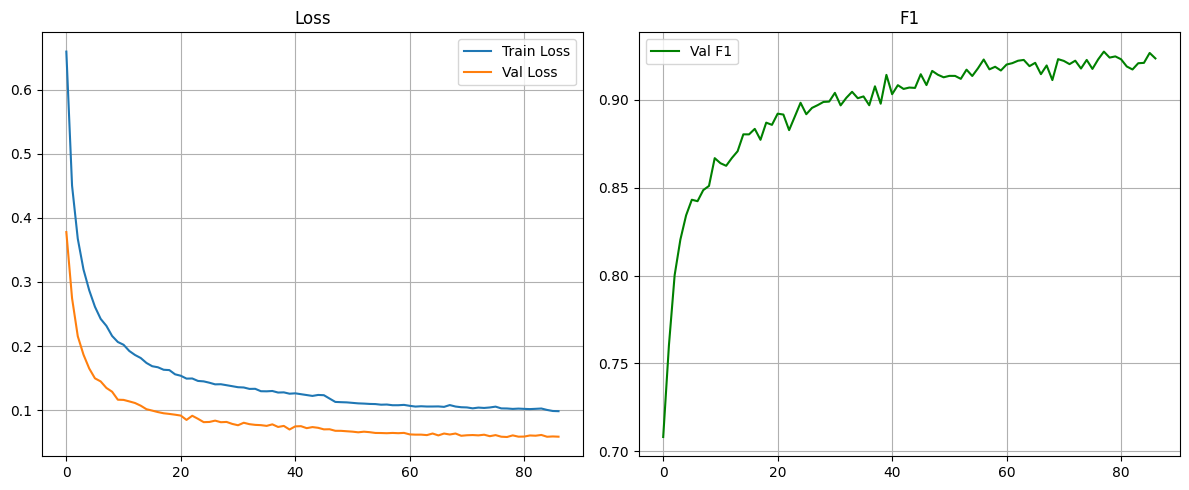


📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.77      0.95      0.85      3599
      calving       0.99      1.00      0.99      3731
     lameness       0.97      1.00      0.99      3729
     mastitis       0.98      1.00      0.99      3727
other_disease       0.95      1.00      0.98      3713
           OK       0.94      0.57      0.71      3208

     accuracy                           0.93     21707
    macro avg       0.93      0.92      0.92     21707
 weighted avg       0.93      0.93      0.92     21707



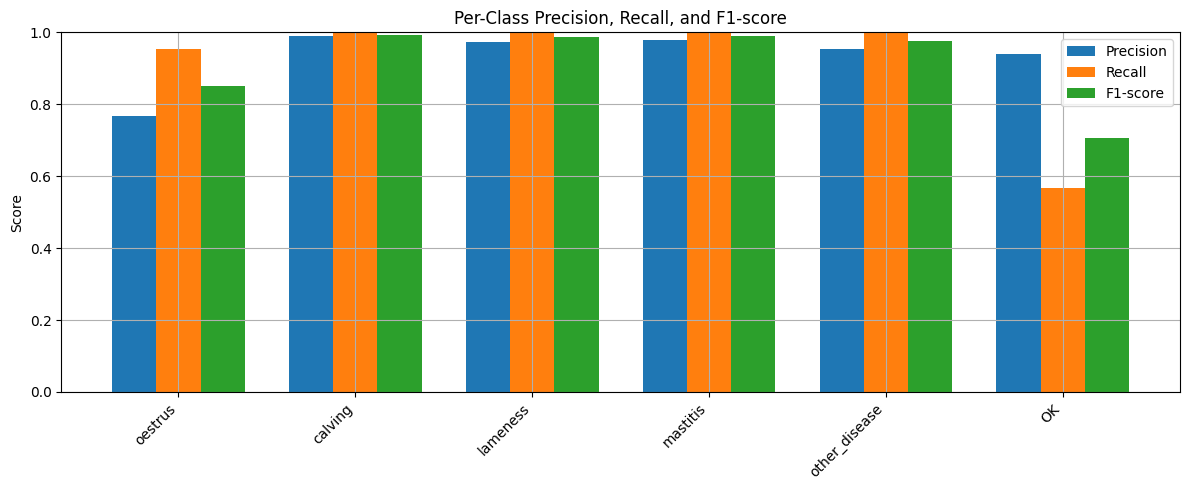


🔍 Macro F1 Score: 0.9172
🔍 Weighted F1 Score: 0.9226

🎯 Optimal per-class thresholds: [0.5 0.5 0.6 0.6 0.5 0.4]


In [4]:
import pandas as pd
from pathlib import Path

# Load your dataset
df = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv"))

# Run the pipeline
model, scaler, results = run_pipeline(
    df=df,
    label_cols=['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
    drop_cols=['cow', 'duration_hours'],
    hidden_dims=[512, 256, 128],
    dropout_rates=[0.5, 0.4, 0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    batch_size=128,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=150,
    use_focal_loss=True,              # 🆕 if you want to use Focal Loss
    use_temperature_scaling=True,   # 🆕 if you want calibrated confidence
    optimize_thresholds=True          # 🆕 for better per-class F1 scores
)


🔄 Running MLP pipeline...


Training:  57%|█████▋    | 86/150 [37:06<27:36, 25.88s/it]   


Early stopping at epoch 87


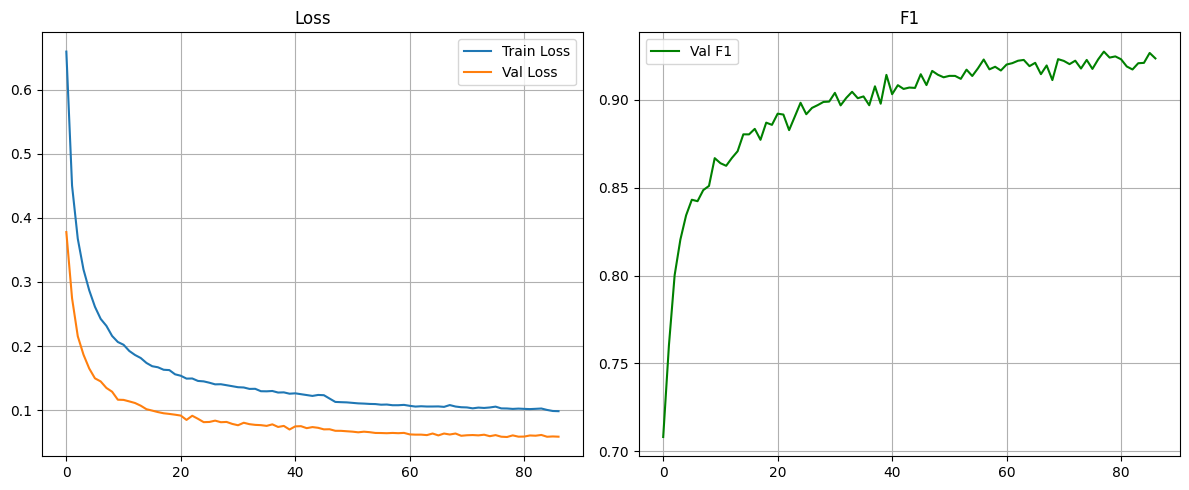


📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.77      0.95      0.85      3599
      calving       0.99      1.00      0.99      3731
     lameness       0.97      1.00      0.99      3729
     mastitis       0.98      1.00      0.99      3727
other_disease       0.95      1.00      0.98      3713
           OK       0.94      0.57      0.71      3208

     accuracy                           0.93     21707
    macro avg       0.93      0.92      0.92     21707
 weighted avg       0.93      0.93      0.92     21707



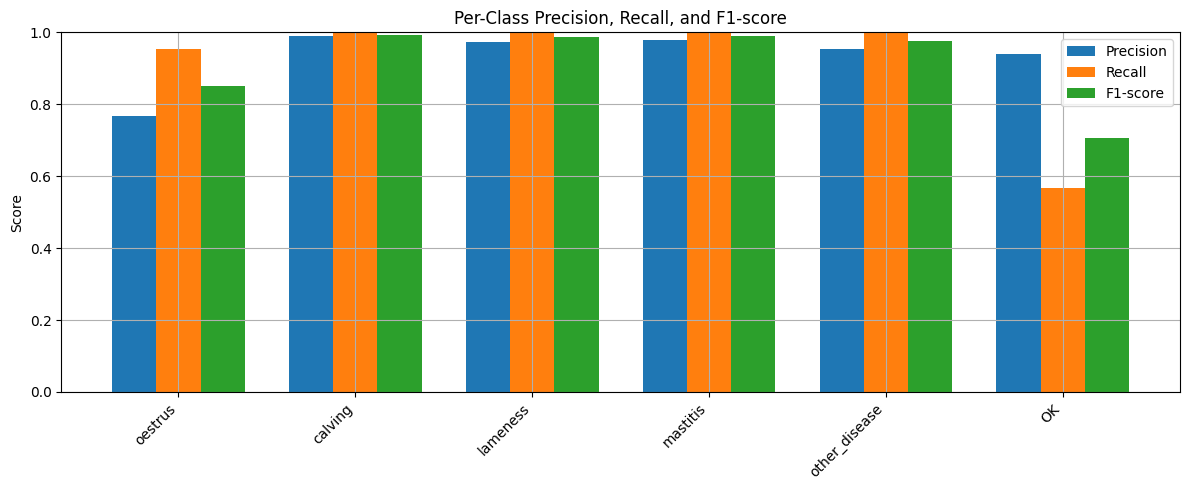


🔍 Macro F1 Score: 0.9172
🔍 Weighted F1 Score: 0.9226

🎯 Optimal per-class thresholds: [0.5 0.5 0.6 0.6 0.5 0.4]


In [ ]:
import pandas as pd
from pathlib import Path

# Load your dataset
df = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv"))

# Run the pipeline
model, scaler, results = run_pipeline(
    df=df,
    label_cols=['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
    drop_cols=['cow', 'duration_hours'],
    hidden_dims=[512, 256, 128],
    dropout_rates=[0.5, 0.4, 0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    batch_size=128,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=150,
    use_focal_loss=True,              # 🆕 if you want to use Focal Loss
    use_temperature_scaling=True,   # 🆕 if you want calibrated confidence
    optimize_thresholds=True          # 🆕 for better per-class F1 scores
)


In [1]:
def run_pipeline(df, label_cols, drop_cols=None,
                 hidden_dims=[512, 256, 128],
                 dropout_rates=[0.5, 0.4, 0.3],
                 activation='leakyrelu',
                 use_batchnorm=True,
                 batch_size=128,
                 lr=0.0005,
                 weight_decay=1e-4,
                 epochs=150,
                 use_focal_loss=True,
                 use_temperature_scaling=True,
                 optimize_thresholds=True):

    print("🔄 Running MLP pipeline...")
    X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
    train_loader, val_loader, test_loader = create_dataloaders(X, y, batch_size=batch_size)

    # Extract class weights with increased weight for 'OK' class (last class, index 5)
    all_train_labels = []
    for _, labels in train_loader:
        all_train_labels.extend(labels.numpy())
    class_weights = compute_class_weights(np.array(all_train_labels), num_classes=len(label_cols), method='balanced')
    ok_class_idx = len(label_cols) - 1  # Assuming 'OK' is the last class
    class_weights[ok_class_idx] *= 2.0  # Double the weight for 'OK' class
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Initialize model
    model = CowHealthMLP(input_dim=X.shape[1], hidden_dims=hidden_dims, num_classes=len(label_cols),
                         dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm)

    # Loss and optimizer
    criterion = FocalLoss(gamma=3.0, weight=class_weights) if use_focal_loss else nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    best_val_loss = float('inf')
    best_model = None
    train_loss_history = []
    val_loss_history = []
    val_f1_history = []
    patience = 30  # Increased patience for more training
    min_delta = 0.0005  # Reduced min_delta for finer stopping
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        val_f1_history.append(val_f1)
        scheduler.step(val_loss)

        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_model:
        model.load_state_dict(best_model)

    # Plot loss/F1
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.legend(); plt.grid(); plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(val_f1_history, label='Val F1', color='green')
    plt.legend(); plt.grid(); plt.title('F1')
    plt.tight_layout(); plt.show()

    # Evaluate on test
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            if use_temperature_scaling:
                outputs = apply_temperature_scaling(outputs, temperature=1.2)  # Reduced temperature
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)

    if optimize_thresholds:
        thresholds = find_best_thresholds(all_probs, all_labels, len(label_cols))
        # Adjust threshold range for finer granularity
        thresholds = np.linspace(0.05, 0.95, 19)  # Finer increments
        best_thresholds = np.zeros(len(label_cols))
        for class_idx in range(len(label_cols)):
            best_f1, best_thresh = 0, 0.5
            for thresh in thresholds:
                preds = (np.array(all_probs)[:, class_idx] > thresh).astype(int)
                true = (np.array(all_labels) == class_idx).astype(int)
                f1 = f1_score(true, preds)
                if f1 > best_f1:
                    best_f1, best_thresh = f1, thresh
            best_thresholds[class_idx] = best_thresh
        thresholds = best_thresholds
        print("\n🎯 Optimal per-class thresholds:", thresholds)

    return model, scaler, {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'thresholds': thresholds if optimize_thresholds else None
    }

🔄 Running MLP pipeline...


Training: 100%|██████████| 150/150 [28:28<00:00, 11.39s/it]


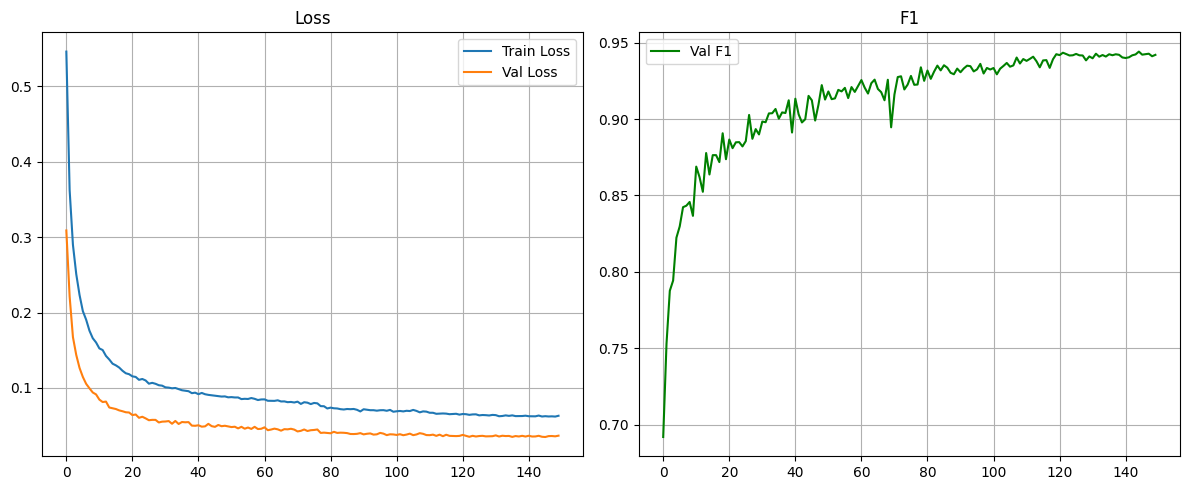


📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.88      0.83      0.85      3599
      calving       0.99      1.00      1.00      3731
     lameness       0.98      1.00      0.99      3729
     mastitis       0.99      1.00      0.99      3727
other_disease       0.96      1.00      0.98      3713
           OK       0.82      0.78      0.80      3208

     accuracy                           0.94     21707
    macro avg       0.93      0.94      0.94     21707
 weighted avg       0.94      0.94      0.94     21707



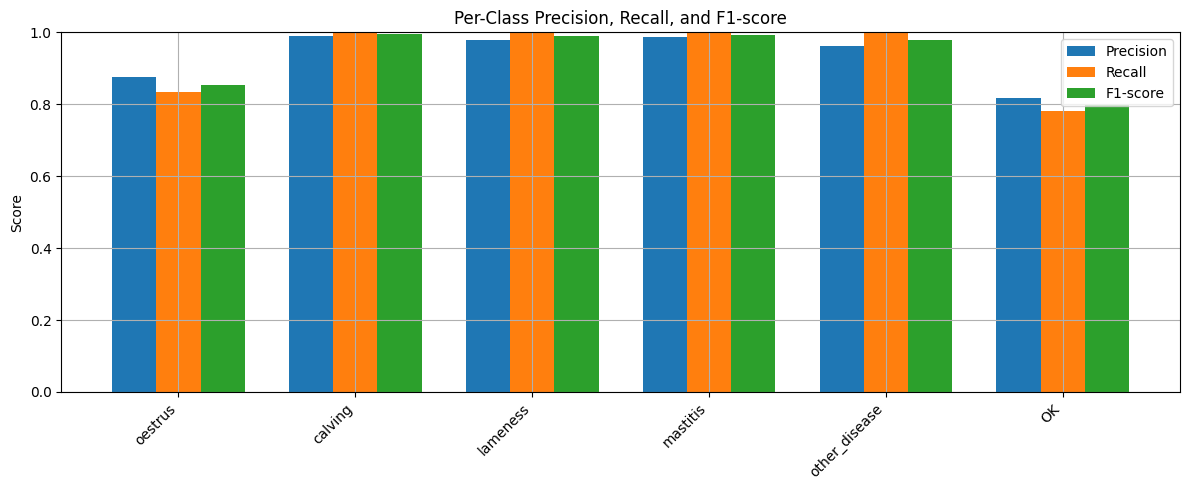


🔍 Macro F1 Score: 0.9351
🔍 Weighted F1 Score: 0.9388

🎯 Optimal per-class thresholds: [0.45 0.5  0.6  0.55 0.55 0.5 ]
Pipeline completed. Results: {'predictions': [2, 3, 1, 2, 4, 0, 2, 4, 4, 1, 2, 0, 5, 2, 5, 3, 4, 3, 1, 0, 4, 1, 0, 3, 0, 3, 3, 5, 1, 3, 4, 0, 2, 1, 5, 4, 5, 1, 2, 1, 1, 5, 4, 4, 5, 5, 1, 3, 0, 1, 1, 2, 1, 1, 5, 1, 2, 2, 0, 4, 4, 1, 4, 3, 4, 3, 4, 0, 2, 2, 0, 3, 2, 2, 2, 2, 5, 3, 2, 3, 2, 5, 2, 3, 1, 5, 3, 5, 4, 1, 5, 3, 1, 4, 4, 3, 3, 1, 0, 1, 0, 0, 2, 1, 4, 0, 1, 5, 4, 2, 4, 5, 2, 5, 1, 3, 3, 3, 4, 1, 2, 0, 1, 2, 5, 2, 4, 4, 2, 3, 2, 3, 1, 3, 2, 1, 5, 1, 1, 4, 1, 0, 3, 3, 1, 2, 3, 2, 4, 4, 4, 2, 0, 1, 5, 3, 4, 1, 1, 4, 5, 4, 0, 5, 2, 4, 5, 4, 2, 2, 3, 2, 5, 2, 0, 1, 3, 3, 1, 5, 1, 0, 0, 0, 0, 5, 1, 2, 3, 4, 4, 0, 1, 0, 2, 5, 1, 0, 3, 4, 5, 1, 0, 1, 2, 0, 0, 1, 5, 4, 3, 5, 2, 3, 1, 3, 1, 5, 3, 0, 1, 0, 2, 1, 5, 2, 4, 5, 5, 1, 5, 4, 0, 1, 2, 1, 2, 2, 1, 2, 0, 2, 4, 2, 0, 5, 0, 0, 3, 3, 4, 1, 2, 5, 3, 0, 4, 4, 0, 5, 0, 1, 1, 4, 5, 0, 2, 0, 1, 0, 2, 4, 3, 0, 2, 0, 5, 1, 3

In [4]:
import pandas as pd
from pathlib import Path

# Load your dataset
df = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv"))

# Run the pipeline
model, scaler, results = run_pipeline(
    df=df,
    label_cols=['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
    drop_cols=['cow', 'duration_hours'],
    hidden_dims=[512, 256, 128],
    dropout_rates=[0.5, 0.4, 0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    batch_size=128,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=150,
    use_focal_loss=True,
    use_temperature_scaling=True,
    optimize_thresholds=True
)

# Optional: Access results
print("Pipeline completed. Results:", results)

In [ ]:
import pandas as pd
from pathlib import Path

# Load your dataset
df = pd.read_csv(Path("C:/Users/lamia/Downloads/augmented_dataset1_trainval.csv"))

# Run the pipeline
model, scaler, results = run_pipeline(
    df=df,
    label_cols=['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK'],
    drop_cols=['cow', 'duration_hours'],
    hidden_dims=[512, 256, 128],
    dropout_rates=[0.5, 0.4, 0.3],
    activation='leakyrelu',
    use_batchnorm=True,
    batch_size=128,
    lr=0.0005,
    weight_decay=1e-4,
    epochs=200,
    use_focal_loss=True,
    use_temperature_scaling=True,
    optimize_thresholds=True
)

# Optional: Access results
print("Pipeline completed. Results:", results)